In [73]:
import f2b
from data import Data
from likelihood import compute_likelihood_blocks, transition_probability, log_likelihood_global


In [25]:
def load_estimated_f2b(station: str, morning_peak: bool) -> list:
    if morning_peak:
        f2b_file_path = "/home/justine/Nextcloud/Cired/Recherche/Econometrie/fail_to_board_probability/f2b_code/f2b/output/f2b_results_morning_peak_" + station + ".csv"
    else:
        f2b_file_path = "/home/justine/Nextcloud/Cired/Recherche/Econometrie/fail_to_board_probability/f2b_code/f2b/output/f2b_results_" + station + ".csv"

    with open(f2b_file_path, "r") as f2b_file:
        f2b_file_content = f2b_file.read()
        f2b_estimated = f2b_file_content.split(",")
        f2b_estimated = [float(f2b) for f2b in f2b_estimated]
        return f2b_estimated

In [3]:
def transition_probability_partial_diff(
    trip_id: int,
    data: Data,
    boarded_run: str,
    headway_run: str,
    f2b_probabilities: list,
    partial_diff_component: int,
) -> float:
    """Function returning the probability of boarding boarded_run
    when arriving at headway_run according to the f2b_probability."""

    headway_run_index = data.runs.index(headway_run)
    boarded_run_index = data.runs.index(boarded_run)
    
    if partial_diff_component >= headway_run_index and partial_diff_component < boarded_run_index:
        failure_probability = 1

        # relative indexing in the list of feasible runs in
        # chronological order for each trip.
        trip_headway_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
            headway_run
        )
        trip_boarded_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
            boarded_run
        )

        for missed_run in data.feasible_runs_by_trip[trip_id][
            trip_headway_run_relative_index:trip_boarded_run_relative_index
        ]:
            missed_run_index = data.runs.index(missed_run)
            if missed_run_index != partial_diff_component:
                failure_probability = (
                    f2b_probabilities[missed_run_index] * failure_probability
                )
        return (1 - f2b_probabilities[boarded_run_index]) * failure_probability

    if partial_diff_component == boarded_run_index:
        if headway_run == boarded_run:
            return -1

        else:
            failure_probability = 1

            # relative indexing in the list of feasible runs in
            # chronological order for each trip.
            trip_headway_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
                headway_run
            )
            trip_boarded_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
                boarded_run
            )

            for missed_run in data.feasible_runs_by_trip[trip_id][
                trip_headway_run_relative_index:trip_boarded_run_relative_index
            ]:
                missed_run_index = data.runs.index(missed_run)
                failure_probability = (
                    f2b_probabilities[missed_run_index] * failure_probability
                )
            return (-1) * failure_probability

    if partial_diff_component < headway_run_index or partial_diff_component > boarded_run_index:
        return 0

In [39]:
def indiv_log_likelihood_partial_diff(    
    trip_id: int,
    data: Data,
    precomputed_blocks: dict,
    f2b_probabilities: list,
    diff_component: int,
    ):
    conditional_exit_duration_proba = 0.
    conditional_exit_duration_proba_diff = 0.

    for headway_boarded_pair in data.headway_boarded_run_pair_by_trip[trip_id]:
        # Pairs are ordered (headway_run, boarded_run)
        headway_run = headway_boarded_pair[0]
        boarded_run = headway_boarded_pair[1]
        block = precomputed_blocks[trip_id, headway_run, boarded_run]

        
        conditional_exit_duration_proba += (
            transition_probability(
                trip_id, data, boarded_run, headway_run, f2b_probabilities
            )
            * block
        )
        conditional_exit_duration_proba_diff += (
            transition_probability_partial_diff(
                trip_id, data, boarded_run, headway_run, f2b_probabilities, diff_component
            )
            * block
        )

    # Derivative of log(P(x) is P'(x)/P(x).
    return conditional_exit_duration_proba_diff/conditional_exit_duration_proba

In [5]:
from yaml import safe_load

origin_station = "VIN"
destination_stations = ["NAT", "LYO", "CHL", "AUB", "ETO", "DEF"]
date = "04/02/2020"
with open(f"/home/justine/Nextcloud/Cired/Recherche/Econometrie/fail_to_board_probability/f2b_code/f2b/parameters_{origin_station}.yml") as file:
        parameters = safe_load(file)
data = Data(date, origin_station, destination_stations)
likelihood_blocks = compute_likelihood_blocks(data, parameters)


Get feasible runs...


100%|██████████| 8458/8458 [00:00<00:00, 9436.21it/s] 


number of too long trips removed: 110
Get runs info...


100%|██████████| 305/305 [00:01<00:00, 266.49it/s]


Order feasible run lists...


100%|██████████| 8336/8336 [00:00<00:00, 1004704.54it/s]


Construct feasible run pairs...


100%|██████████| 8336/8336 [00:00<00:00, 681912.86it/s]


(Offline) Compute likelihood blocks...


100%|██████████| 8336/8336 [00:07<00:00, 1112.85it/s]


In [101]:
f2b_estimation = [0 for _ in range(len(data.runs))]
log_likelihood = [log_likelihood_global(f2b_estimation, data, likelihood_blocks)]

log_likelihood_gradient = [0 for _ in range(len(data.runs))]
for diff_component in range(len(data.runs)):
    for trip_id in data.trips.index:
            log_likelihood_gradient[diff_component] += indiv_log_likelihood_partial_diff(trip_id, data, likelihood_blocks, f2b_estimation, diff_component)

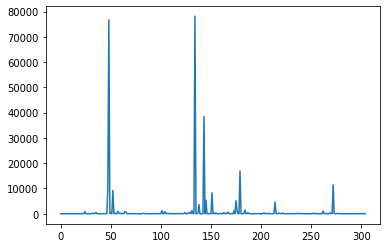

In [102]:
from matplotlib import pyplot
pyplot.plot(log_likelihood_gradient)
pyplot.show()

In [103]:
indices_to_correct = []
indices_neighboors_to_correct = []
for proba_index in range(len(data.runs)):
    if log_likelihood_gradient[proba_index] > 100:
        indices_to_correct.append(proba_index)
        if proba_index-1 >= 0:
            indices_neighboors_to_correct.append(proba_index-1)
        if proba_index-2 >= 0:
            indices_neighboors_to_correct.append(proba_index-2)
        if proba_index+1 <len(data.runs):
            indices_neighboors_to_correct.append(proba_index+1)
        if proba_index+2 <len(data.runs):
            indices_neighboors_to_correct.append(proba_index+2)

In [104]:
for i in range(10):
    for proba_to_correct_index in indices_to_correct:
        f2b_estimation[proba_to_correct_index] +=0.05
    for proba_to_correct_index in indices_neighboors_to_correct:
        f2b_estimation[proba_to_correct_index] +=0.05   
    log_likelihood.append(log_likelihood_global(f2b_estimation, data, likelihood_blocks))
    log_likelihood_gradient = [0 for _ in range(len(data.runs))]

    for diff_component in range(len(data.runs)):
        for trip_id in data.trips.index:
            log_likelihood_gradient[diff_component] += indiv_log_likelihood_partial_diff(trip_id, data, likelihood_blocks, f2b_estimation, diff_component)
    
    indices_to_correct = []
    indices_neighboors_to_correct = []
    for proba_index in range(len(data.runs)):
        if log_likelihood_gradient[proba_index] > 100:
            indices_to_correct.append(proba_index)
            if proba_index-1 >= 0:
                indices_neighboors_to_correct.append(proba_index-1)
            if proba_index-2 >= 0:
                indices_neighboors_to_correct.append(proba_index-2)
            if proba_index+1 <len(data.runs):
                indices_neighboors_to_correct.append(proba_index+1)
            if proba_index+2 <len(data.runs):
                indices_neighboors_to_correct.append(proba_index+2)

In [110]:
log_likelihood

[-46662.43673206189,
 -46081.55846050578,
 -46077.56985275371,
 -46082.17211154094,
 -46098.11545756874,
 -46124.339382122635,
 -46124.339382122635,
 -46124.339382122635,
 -46124.339382122635,
 -46124.339382122635,
 -46124.339382122635]

In [122]:
f2b_estimation = [0 for _ in range(len(data.runs))]

for diff_component in range(len(data.runs)):
    likelihoods = []
    proba_to_test = [0]
    for i in range(1,100):
        proba_to_test.append(1/i)

    for proba in proba_to_test:
        f2b_estimation[diff_component] = proba
        likelihoods.append(log_likelihood_global(f2b_estimation, data, likelihood_blocks))
    new_proba_index = likelihoods.index(max(likelihoods))
    new_proba = proba_to_test[new_proba_index]
    f2b_estimation[diff_component] = new_proba


In [125]:
log_likelihood_global(f2b_estimation, data, likelihood_blocks)

-45782.27940296616

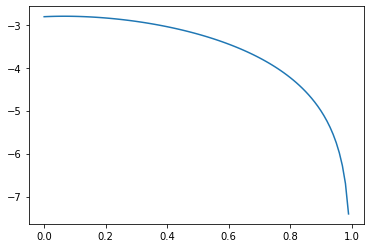

In [7]:
from matplotlib import pyplot
from numpy import linspace
from math import log 

X = linspace(0,0.99, 100)
Y = [log((1-x)*0.2+x*0.6) + log((1-x)*0.3+x*0.1) + log((1-x)) for x in X]
pyplot.plot(X,Y)
pyplot.show()